# File Info
Learns non-chaotic lorenz with $\rho(t)$ transitioning from 10 to 14 using piecewise neural odes. 

Uses a custom loss function which weights loss in each partition equally - l1 loss

In [ ]:
# Import the necessary packages:
    
from torchdiffeq import odeint_adjoint as odeint
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits import mplot3d
from numpy import linalg as la
from scipy import stats
from scipy import spatial as sp
from scipy import integrate as integ
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from ipywidgets import interact, IntSlider


#import Networkx as net
#import Plot3D as plot3d

#Neural ODE library
import NODE_Dynamic_Bifurcation_Parameter.Neural_ODEs_v1 as nodes
import NODE_Dynamic_Bifurcation_Parameter.DynamicalSystems as ds


#set random seed to 107
torch.manual_seed(107)
np.random.seed(107)

# Generating Data

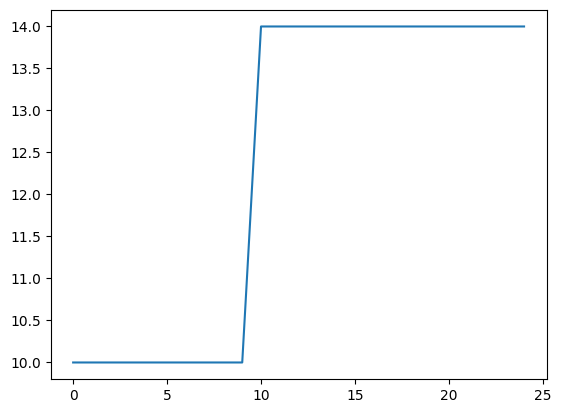

In [2]:
#r_vals = np.arange(14, 15, 1, dtype=np.float32)
r_vals = [10.0, 14.0]
def rho(t, r_vals = r_vals, step = 10):
    if t < step:
        return r_vals[0]
    elif t >= step:
        return r_vals[1]

plt.plot([rho(t) for t in range(0, 25)])

In [3]:
lorenz = ds.Lorenz(rho = rho)

#Generating data from Lorenz System with fixed parameters
dt = 0.05
initial_conditions = [[1.0, 1.0, 1.0], [-1.0, -1.0, 1.0]]
time_spans = [(0, 15)]
list = []

for t_span in time_spans:
    out = lorenz.solve(x0 = initial_conditions, t_span = t_span, dt = dt)
    list.append(np.expand_dims(out, axis=0))

data_full = np.concatenate(list, axis=0)
data_full.shape

(1, 300, 2, 3)

### Normalizing Data

In [4]:
norm = nodes.normalize_data(data_full.reshape(-1, 3))
data_norm = norm.normalize(data_full)

## Plotting 

In [6]:
def plot_interact(index):
    #Normalised Plot
    fig = plt.figure(figsize=(6, 8))
    ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    #ax1.set_title('r = '+str(r_list[2*index]), fontsize=14)
    ax1.plot(xs=data_norm[:index, 0, 0], ys=data_norm[:index, 0, 1], zs=data_norm[:index, 0, 2], color = 'black', linewidth = 1 )
    ax1.plot(xs=data_norm[:index, 1, 0], ys=data_norm[:index, 1, 1], zs=data_norm[:index, 1, 2], color = 'red', linewidth = 1)

    ax1.plot(xs=data_norm[:index, 0, 0], ys=data_norm[:index, 0, 1], zs=data_norm[:index, 0, 2], color = 'black', linewidth = 1 )
    ax1.plot(xs=data_norm[:index, 1, 0], ys=data_norm[:index, 1, 1], zs=data_norm[:index, 1, 2], color = 'red', linewidth = 1)

    ax1.plot(xs=data_norm[:index, 0, 0], ys=data_norm[:index, 0, 1], zs=data_norm[:index, 0, 2], color = 'black', linewidth = 1 )
    ax1.plot(xs=data_norm[:index, 1, 0], ys=data_norm[:index, 1, 1], zs=data_norm[:index, 1, 2], color = 'red', linewidth = 1)


    ax1.view_init(elev = 30, azim = 120)

    

In [6]:
data_norm[0, :, 0, 0].shape

(300,)

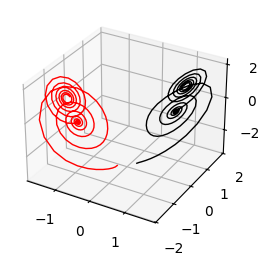

In [5]:

fig = plt.figure(figsize=(10, 15))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
#ax1.set_title('r = '+str(r_list[2*index]), fontsize=14)
ax1.plot(xs=data_norm[0, :, 0, 0], ys=data_norm[0, :, 0, 1], zs=data_norm[0, :, 0, 2], color = 'black', linewidth = 1 )
ax1.plot(xs=data_norm[0, :, 1, 0], ys=data_norm[0, :, 1, 1], zs=data_norm[0, :, 1, 2], color = 'red', linewidth = 1)   



# Training Neural ODE

## Custom Loss function 

In [6]:
class PiecewiseLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss_fn = nn.L1Loss()

    def forward(self, input, target, breakpoints, time_tensor):
        index = torch.searchsorted(time_tensor, breakpoints)
        total_loss = 0.0
        for i in range(index.shape[0]-1):
            input_segment = input[:, index[i]:index[i+1]]
            target_segment = target[:, index[i]:index[i+1]]
            #print('input_segment.shape, target_segment.shape', input_segment.shape, target_segment.shape)
            segment_loss = self.loss_fn(input_segment, target_segment)
            total_loss += segment_loss
            
       

        return total_loss

## Model Setup 

In [7]:
model = nodes.Piecewise_Auto_NODE(spatial_dim=3, depth=4, width = 50, time_range=[0, 15], num_breakpoints=1, activation_func=nn.Tanh())

In [8]:
#Saving loss and setting optimiser 
loss_list = []
breakpt_list = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


#Putting data into tensor 
#t_eval_tensor =  torch.tensor(np.arange(tstart, tfinal, dt))
training_data_tensor = torch.tensor(data_norm)

In [9]:
times = np.array([np.arange(time_spans[i][0], time_spans[i][1], dt) for i in range(len(time_spans))])
t_eval_tensor = torch.tensor(times)
t_eval_tensor.shape

torch.Size([1, 300])

## Single Loop 

In [10]:
training_data_tensor.shape

torch.Size([1, 300, 2, 3])

In [11]:
model.breakpoints[1] = torch.tensor(10.0)

In [12]:
model.breakpoints[1] = torch.tensor(10.0)
model.break_params = nn.Parameter(torch.tensor([10.0], requires_grad=True))

In [15]:
#Single training loop
optimizer.zero_grad()

pred_x_list = []
for i in range(t_eval_tensor.shape[0]):

    pred_x_temp = odeint(model, training_data_tensor[i, 0, :, :].float(), t_eval_tensor[i, :].float(), method='rk4', options={'step_size': dt})
    pred_x_list.append(pred_x_temp)

pred_x = torch.stack(pred_x_list, dim=0)

loss_fn = PiecewiseLoss()
train_loss = loss_fn(pred_x, training_data_tensor.float(), breakpoints=model.breakpoints, time_tensor=t_eval_tensor[i, :].float())

train_loss.backward()
optimizer.step()

breakpt_list.append(model.breakpoints[1].item())
print('Total Loss: ', train_loss)
print('Gradient of Breakpoints:', model.break_params.grad)
print('')


Total Loss:  tensor(1.9555, grad_fn=<AddBackward0>)
Gradient of Breakpoints: tensor([0.3299])



## Main Training Loop

In [16]:
def batch(data: torch.tensor, t: torch.tensor, batch_length: int, num_batch: int): # data shape (traj, dim, time) #All traj same length 
    '''
    Generates batches of data for training. 

    Input shape should be (time, traj, dim).

    Modifed to allow for multiple time spans

    Parameters:
    -----------       
    data : torch.tensor
        The full dataset from which to sample batches. (num_time_spans, time, traj, dim)

    t : torch.tensor
        The corresponding time tensor. (num_time_spans, time)
    '''
    data_length = data.shape[1]
    if batch_length >= data_length:
        raise ValueError("Batch length must be less than the length of the data.")
    else:
    #num_traj = data.shape[0]
        #traj_indices = np.random.randint(0, num_traj, batch_size)
        ic_indices = np.random.randint(0, data_length - batch_length, num_batch)

        batch_list = []
        batch_time_list = []

        for i in range(0, num_batch):
            batch_list.append(data[:, ic_indices[i]:ic_indices[i]+batch_length, :, :].float())
            batch_time_list.append(t[:, ic_indices[i]:ic_indices[i]+batch_length].float().requires_grad_(True))
        
        #Each batch has shape (num_time_spans, batch_length, traj, dim) and each batch time has shape (num_time_spans, batch_length)

        return batch_list, batch_time_list

In [18]:
training_data_tensor.shape

torch.Size([1, 300, 2, 3])

In [23]:
batch_length = 20
num_batch = 15
num_epochs = 2000
#Loss function will not scale to more time scales. piecewise loss function only takes one timescale. 

for epoch in tqdm(range(num_epochs)):
    batch_list, batch_time_list = batch(training_data_tensor, t_eval_tensor, batch_length=batch_length, num_batch=num_batch)
    for i in range(0, num_batch):
        batch_i = batch_list[i]
        batch_time_i = batch_time_list[i]

        optimizer.zero_grad()

        #Predicting the trajectory
  
        pred_x_list = []
        for i in range(t_eval_tensor.shape[0]):
            pred_x_temp = odeint(model, batch_i[i, 0, :, :], batch_time_i[i, :], method='rk4', options={'step_size': dt})
            pred_x_list.append(pred_x_temp)

        pred_x = torch.stack(pred_x_list, dim=0)

        #Calculating loss
        loss = loss_fn(pred_x, batch_i.float(), breakpoints=model.breakpoints, time_tensor=batch_time_i[0, :].float()) # Will not scale here 
        #loss_list.append(loss.item())

        #Backpropagation
        loss.backward()
        optimizer.step()

    if epoch%20==0:
            #Calculate training loss
            with torch.no_grad():
                temp_list = []
                pred_x_list = []
                for i in range(t_eval_tensor.shape[0]):

                    pred_x_temp = odeint(model, training_data_tensor[i, 0, :, :].float(), t_eval_tensor[i, :].float(), method='rk4', options={'step_size': dt})
                    pred_x_list.append(pred_x_temp)

                pred_x = torch.stack(pred_x_list, dim=0)
                
                train_loss = loss_fn(pred_x, training_data_tensor.float(), breakpoints=model.breakpoints, time_tensor=t_eval_tensor[0, :].float()) # same issue here
                breakpt_list.append(model.break_params.item())
                loss_list.append(train_loss.item())


    if epoch % 20 == 0:
            print(f'Epoch {epoch}, Loss: {train_loss.item()}')
     
    
   

  0%|          | 1/2000 [00:05<2:49:28,  5.09s/it]

Epoch 0, Loss: 0.3387708365917206


  1%|          | 21/2000 [01:34<2:33:07,  4.64s/it]

Epoch 20, Loss: 0.3071824312210083


  2%|▏         | 41/2000 [03:03<2:31:11,  4.63s/it]

Epoch 40, Loss: 0.29800745844841003


  3%|▎         | 61/2000 [04:35<2:31:31,  4.69s/it]

Epoch 60, Loss: 0.3567635715007782


  4%|▍         | 81/2000 [06:08<2:29:43,  4.68s/it]

Epoch 80, Loss: 1.6204473972320557


  5%|▌         | 101/2000 [07:41<2:26:18,  4.62s/it]

Epoch 100, Loss: 1.6113231182098389


  6%|▌         | 121/2000 [09:12<2:26:49,  4.69s/it]

Epoch 120, Loss: 1.6685740947723389


  7%|▋         | 141/2000 [10:42<2:23:44,  4.64s/it]

Epoch 140, Loss: 0.3633313477039337


  8%|▊         | 161/2000 [12:13<2:24:25,  4.71s/it]

Epoch 160, Loss: 0.3505552411079407


  9%|▉         | 181/2000 [13:45<2:23:40,  4.74s/it]

Epoch 180, Loss: 0.33961033821105957


 10%|█         | 201/2000 [15:18<2:19:19,  4.65s/it]

Epoch 200, Loss: 0.35350343585014343


 11%|█         | 221/2000 [16:50<2:19:17,  4.70s/it]

Epoch 220, Loss: 0.32378774881362915


 12%|█▏        | 241/2000 [18:21<2:16:33,  4.66s/it]

Epoch 240, Loss: 0.29956644773483276


 13%|█▎        | 261/2000 [19:53<2:17:47,  4.75s/it]

Epoch 260, Loss: 0.29849496483802795


 14%|█▍        | 281/2000 [21:26<2:14:59,  4.71s/it]

Epoch 280, Loss: 0.30970972776412964


 15%|█▌        | 301/2000 [22:58<2:14:21,  4.74s/it]

Epoch 300, Loss: 0.30768394470214844


 16%|█▌        | 321/2000 [24:31<2:14:13,  4.80s/it]

Epoch 320, Loss: 0.29660817980766296


 17%|█▋        | 341/2000 [26:02<2:13:22,  4.82s/it]

Epoch 340, Loss: 0.3217369019985199


 18%|█▊        | 361/2000 [27:42<2:17:17,  5.03s/it]

Epoch 360, Loss: 0.3452834486961365


 19%|█▉        | 381/2000 [29:17<2:11:11,  4.86s/it]

Epoch 380, Loss: 0.31372004747390747


 20%|██        | 401/2000 [30:49<2:10:09,  4.88s/it]

Epoch 400, Loss: 0.2947538495063782


 21%|██        | 421/2000 [32:22<2:04:35,  4.73s/it]

Epoch 420, Loss: 0.29561764001846313


 22%|██▏       | 441/2000 [33:55<2:05:47,  4.84s/it]

Epoch 440, Loss: 0.31786176562309265


 23%|██▎       | 461/2000 [35:29<2:01:12,  4.73s/it]

Epoch 460, Loss: 0.28847065567970276


 24%|██▍       | 481/2000 [37:02<2:02:01,  4.82s/it]

Epoch 480, Loss: 0.32271134853363037


 25%|██▌       | 501/2000 [38:35<2:01:41,  4.87s/it]

Epoch 500, Loss: 0.3430514931678772


 26%|██▌       | 521/2000 [40:08<1:58:33,  4.81s/it]

Epoch 520, Loss: 0.3295783996582031


 27%|██▋       | 541/2000 [41:40<1:55:58,  4.77s/it]

Epoch 540, Loss: 0.34385332465171814


 28%|██▊       | 561/2000 [43:13<1:54:56,  4.79s/it]

Epoch 560, Loss: 0.40240752696990967


 29%|██▉       | 581/2000 [44:46<1:54:56,  4.86s/it]

Epoch 580, Loss: 0.3065834045410156


 30%|███       | 601/2000 [46:19<1:51:37,  4.79s/it]

Epoch 600, Loss: 0.28122952580451965


 31%|███       | 621/2000 [47:51<1:48:55,  4.74s/it]

Epoch 620, Loss: 0.3154212236404419


 32%|███▏      | 641/2000 [49:24<1:48:48,  4.80s/it]

Epoch 640, Loss: 0.30540215969085693


 33%|███▎      | 661/2000 [50:57<1:47:33,  4.82s/it]

Epoch 660, Loss: 0.38475683331489563


 34%|███▍      | 681/2000 [52:30<1:46:25,  4.84s/it]

Epoch 680, Loss: 0.27273181080818176


 35%|███▌      | 701/2000 [54:03<1:43:29,  4.78s/it]

Epoch 700, Loss: 0.2872084975242615


 36%|███▌      | 721/2000 [55:36<1:42:30,  4.81s/it]

Epoch 720, Loss: 0.30024266242980957


 37%|███▋      | 741/2000 [57:08<1:44:02,  4.96s/it]

Epoch 740, Loss: 0.3400522768497467


 38%|███▊      | 761/2000 [58:40<1:37:21,  4.71s/it]

Epoch 760, Loss: 0.32976192235946655


 39%|███▉      | 781/2000 [1:00:12<1:35:55,  4.72s/it]

Epoch 780, Loss: 0.2960612177848816


 40%|████      | 801/2000 [1:01:45<1:36:29,  4.83s/it]

Epoch 800, Loss: 0.2958495020866394


 41%|████      | 821/2000 [1:03:18<1:35:01,  4.84s/it]

Epoch 820, Loss: 0.29695069789886475


 42%|████▏     | 841/2000 [1:04:50<1:31:47,  4.75s/it]

Epoch 840, Loss: 0.4083721339702606


 43%|████▎     | 861/2000 [1:06:21<1:31:14,  4.81s/it]

Epoch 860, Loss: 0.31721019744873047


 44%|████▍     | 881/2000 [1:07:54<1:29:38,  4.81s/it]

Epoch 880, Loss: 0.3591751456260681


 45%|████▌     | 901/2000 [1:09:25<1:25:55,  4.69s/it]

Epoch 900, Loss: 0.32891571521759033


 46%|████▌     | 921/2000 [1:10:57<1:24:50,  4.72s/it]

Epoch 920, Loss: 0.39551180601119995


 47%|████▋     | 941/2000 [1:12:30<1:24:58,  4.81s/it]

Epoch 940, Loss: 0.29902249574661255


 48%|████▊     | 961/2000 [1:14:02<1:21:26,  4.70s/it]

Epoch 960, Loss: 0.2835996448993683


 49%|████▉     | 981/2000 [1:15:34<1:21:24,  4.79s/it]

Epoch 980, Loss: 0.30039966106414795


 50%|█████     | 1001/2000 [1:17:06<1:19:30,  4.78s/it]

Epoch 1000, Loss: 0.31941521167755127


 51%|█████     | 1021/2000 [1:18:39<1:18:37,  4.82s/it]

Epoch 1020, Loss: 0.3505071699619293


 52%|█████▏    | 1041/2000 [1:20:21<1:25:36,  5.36s/it]

Epoch 1040, Loss: 0.46423521637916565


 53%|█████▎    | 1061/2000 [1:22:06<1:25:12,  5.44s/it]

Epoch 1060, Loss: 0.36507582664489746


 54%|█████▍    | 1081/2000 [1:23:49<1:22:26,  5.38s/it]

Epoch 1080, Loss: 0.3660009503364563


 55%|█████▌    | 1101/2000 [1:25:33<1:21:00,  5.41s/it]

Epoch 1100, Loss: 0.324043333530426


 56%|█████▌    | 1121/2000 [1:26:48<39:34,  2.70s/it]  

Epoch 1120, Loss: 0.3020390570163727


 57%|█████▋    | 1141/2000 [1:27:38<36:54,  2.58s/it]

Epoch 1140, Loss: 0.31891942024230957


 58%|█████▊    | 1161/2000 [1:28:28<35:39,  2.55s/it]

Epoch 1160, Loss: 0.27874404191970825


 59%|█████▉    | 1181/2000 [1:29:19<35:08,  2.57s/it]

Epoch 1180, Loss: 0.30570924282073975


 60%|██████    | 1201/2000 [1:30:11<35:31,  2.67s/it]

Epoch 1200, Loss: 0.3253087103366852


 61%|██████    | 1221/2000 [1:31:02<34:41,  2.67s/it]

Epoch 1220, Loss: 0.3046475052833557


 62%|██████▏   | 1241/2000 [1:31:52<33:19,  2.63s/it]

Epoch 1240, Loss: 0.27106860280036926


 63%|██████▎   | 1261/2000 [1:32:44<32:22,  2.63s/it]

Epoch 1260, Loss: 0.306192010641098


 64%|██████▍   | 1281/2000 [1:33:35<31:11,  2.60s/it]

Epoch 1280, Loss: 0.34676530957221985


 65%|██████▌   | 1301/2000 [1:34:27<30:36,  2.63s/it]

Epoch 1300, Loss: 0.3234409987926483


 66%|██████▌   | 1321/2000 [1:35:18<29:36,  2.62s/it]

Epoch 1320, Loss: 0.3169213831424713


 67%|██████▋   | 1341/2000 [1:36:10<29:05,  2.65s/it]

Epoch 1340, Loss: 0.32251864671707153


 68%|██████▊   | 1361/2000 [1:37:04<29:50,  2.80s/it]

Epoch 1360, Loss: 0.3258647620677948


 69%|██████▉   | 1381/2000 [1:37:58<28:26,  2.76s/it]

Epoch 1380, Loss: 0.2808787524700165


 70%|███████   | 1401/2000 [1:38:52<27:35,  2.76s/it]

Epoch 1400, Loss: 0.27147406339645386


 71%|███████   | 1421/2000 [1:39:46<27:09,  2.81s/it]

Epoch 1420, Loss: 0.3378482162952423


 72%|███████▏  | 1441/2000 [1:40:40<25:41,  2.76s/it]

Epoch 1440, Loss: 0.3094714879989624


 73%|███████▎  | 1461/2000 [1:41:33<24:20,  2.71s/it]

Epoch 1460, Loss: 0.2874312698841095


 74%|███████▍  | 1481/2000 [1:42:27<24:34,  2.84s/it]

Epoch 1480, Loss: 0.2970021963119507


 75%|███████▌  | 1501/2000 [1:43:20<22:49,  2.75s/it]

Epoch 1500, Loss: 0.35474759340286255


 76%|███████▌  | 1521/2000 [1:44:14<22:23,  2.80s/it]

Epoch 1520, Loss: 0.3152298629283905


 77%|███████▋  | 1541/2000 [1:45:08<21:14,  2.78s/it]

Epoch 1540, Loss: 0.33595263957977295


 78%|███████▊  | 1561/2000 [1:46:01<20:02,  2.74s/it]

Epoch 1560, Loss: 0.31459784507751465


 79%|███████▉  | 1581/2000 [1:46:54<19:26,  2.78s/it]

Epoch 1580, Loss: 0.3212832808494568


 80%|████████  | 1601/2000 [1:47:48<18:37,  2.80s/it]

Epoch 1600, Loss: 0.23646792769432068


 81%|████████  | 1621/2000 [1:48:42<17:56,  2.84s/it]

Epoch 1620, Loss: 0.3409601151943207


 82%|████████▏ | 1641/2000 [1:49:36<16:40,  2.79s/it]

Epoch 1640, Loss: 0.3016089200973511


 83%|████████▎ | 1661/2000 [1:50:29<15:24,  2.73s/it]

Epoch 1660, Loss: 0.3476647436618805


 84%|████████▍ | 1681/2000 [1:51:23<14:44,  2.77s/it]

Epoch 1680, Loss: 0.2953447103500366


 85%|████████▌ | 1701/2000 [1:52:17<13:43,  2.76s/it]

Epoch 1700, Loss: 0.3595465421676636


 86%|████████▌ | 1721/2000 [1:53:11<12:56,  2.78s/it]

Epoch 1720, Loss: 0.27911412715911865


 87%|████████▋ | 1741/2000 [1:54:05<12:05,  2.80s/it]

Epoch 1740, Loss: 0.2909514307975769


 88%|████████▊ | 1761/2000 [1:54:59<11:02,  2.77s/it]

Epoch 1760, Loss: 0.3270297050476074


 89%|████████▉ | 1781/2000 [1:55:52<09:55,  2.72s/it]

Epoch 1780, Loss: 0.30221113562583923


 90%|█████████ | 1801/2000 [1:56:46<09:14,  2.79s/it]

Epoch 1800, Loss: 0.2910153269767761


 91%|█████████ | 1821/2000 [1:57:41<08:18,  2.79s/it]

Epoch 1820, Loss: 0.3387361764907837


 92%|█████████▏| 1841/2000 [1:58:35<07:32,  2.84s/it]

Epoch 1840, Loss: 0.29746758937835693


 93%|█████████▎| 1861/2000 [1:59:29<06:31,  2.82s/it]

Epoch 1860, Loss: 0.2730790972709656


 94%|█████████▍| 1881/2000 [2:00:23<05:33,  2.81s/it]

Epoch 1880, Loss: 0.3105844557285309


 95%|█████████▌| 1901/2000 [2:01:17<04:41,  2.85s/it]

Epoch 1900, Loss: 0.2789892852306366


 96%|█████████▌| 1921/2000 [2:02:11<03:34,  2.71s/it]

Epoch 1920, Loss: 0.30352309346199036


 97%|█████████▋| 1941/2000 [2:03:06<02:48,  2.86s/it]

Epoch 1940, Loss: 0.3036687672138214


 98%|█████████▊| 1961/2000 [2:04:00<01:51,  2.85s/it]

Epoch 1960, Loss: 0.272164911031723


 99%|█████████▉| 1981/2000 [2:04:54<00:53,  2.83s/it]

Epoch 1980, Loss: 0.32449787855148315


100%|██████████| 2000/2000 [2:05:45<00:00,  3.77s/it]


## Plotting results

In [30]:
np.savetxt('Data/PA_NODE_Bif_Lorenz_v7_adjlossL2.csv', np.array(loss_list))

Text(0.5, 0, 'Epochs')

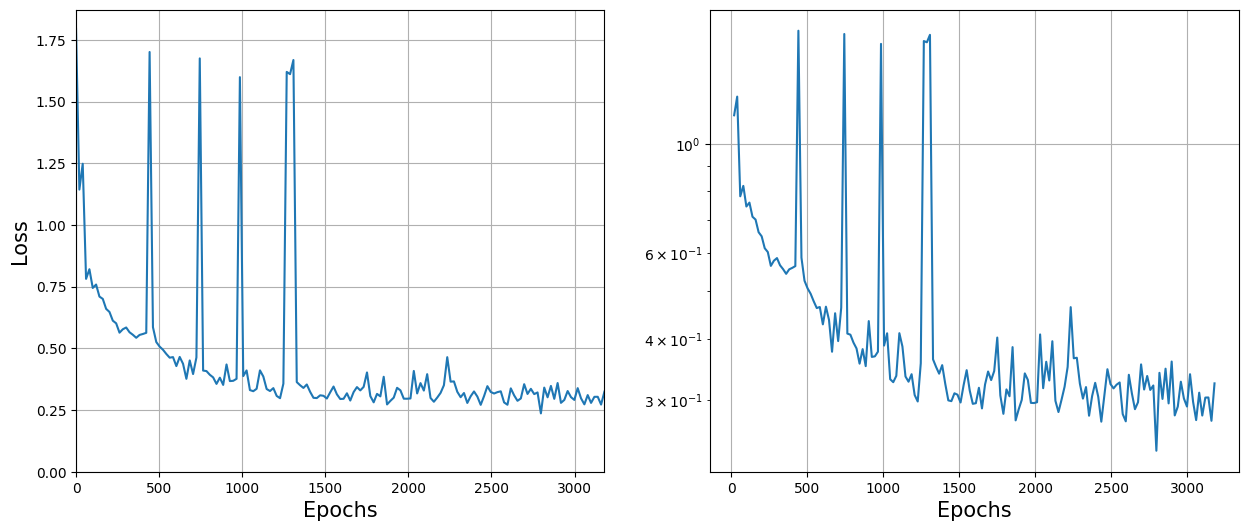

In [24]:
### Analysis  
epochs = len(loss_list)*20
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1)

ax.plot(np.linspace(0, epochs, len(loss_list)), loss_list)
ax.grid()

ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlim(0, epochs)
ax.set_ylim(bottom=0)

ax2 = fig.add_subplot(1, 2, 2)

e_pts = np.linspace(0, epochs, len(loss_list))
ax2.plot(e_pts[1:], loss_list[1:])
#ax2.set_ylim()
ax2.grid()
#plt.xscale('log')~
#
ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.set_xlabel('Epochs', fontsize=15)

In [21]:
t_Start_pred = 0; t_Final_pred = 30
t_eval_pred = torch.arange(t_Start_pred, t_Final_pred, dt)
node_data = odeint(model, training_data_tensor[0, 0, :, :].float(), t_eval_pred, method='rk4', options={'step_size': dt})

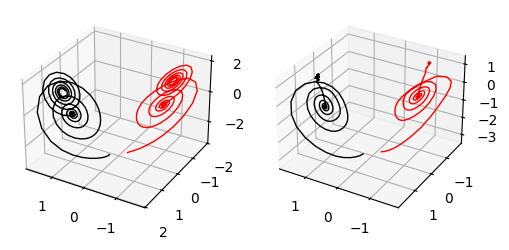

In [25]:
#Plotting results
fig = plt.figure(figsize=(6, 8))

#First Plot
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot(xs=training_data_tensor[0, :, 0, 0], ys=training_data_tensor[0, :, 0, 1], zs=training_data_tensor[0, :, 0, 2], color = 'black', linewidth = 1 )
ax1.plot(xs=training_data_tensor[0, :, 1, 0], ys=training_data_tensor[0, :, 1, 1], zs=training_data_tensor[0, :, 1, 2], color = 'red', linewidth = 1 )

#ax1.plot(xs=node_data[:, 0].detach().numpy(), ys=node_data[:, 1].detach().numpy(), zs=node_data[:, 2].detach().numpy(), color='red', linewidth=1)
ax1.view_init(elev = 30, azim = 120)


#Second Plot 
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot(xs=node_data[:, 0, 0].detach().numpy(), ys=node_data[:, 0, 1].detach().numpy(), zs=node_data[:, 0, 2].detach().numpy(), color = 'black', linewidth = 1 )
ax2.plot(xs=node_data[:, 1, 0].detach().numpy(), ys=node_data[:, 1, 1].detach().numpy(), zs=node_data[:, 1, 2].detach().numpy(), color = 'red', linewidth = 1 )

ax2.view_init(elev = 30, azim = 120)

plt.show()

In [26]:

def plot_interact(index):
    #Normalised Plot
    fig = plt.figure(figsize=(6, 8))
    ax1 = fig.add_subplot(1, 1, 1, projection='3d')
    #ax1.set_title('r = '+str(r_list[2*index]), fontsize=14)
    ax1.plot(xs=data_norm[0, :index, 0, 0], ys=data_norm[0, :index, 0, 1], zs=data_norm[0, :index, 0, 2], color = 'black', linewidth = 1 )
    ax1.plot(xs=data_norm[0, :index, 1, 0], ys=data_norm[0, :index, 1, 1], zs=data_norm[0, :index, 1, 2], color = 'red', linewidth = 1)


    ax1.view_init(elev = 30, azim = 120)

In [53]:
def plot_interact2(index):
        #Plotting results
        fig = plt.figure(figsize=(6, 8))

        #First Plot
        ax1 = fig.add_subplot(1, 2, 1, projection='3d')
        ax1.plot(xs=training_data_tensor[0, :index, 0, 0], ys=training_data_tensor[0, :index, 0, 1], zs=training_data_tensor[0, :index, 0, 2], color = 'black', linewidth = 1 )
        ax1.plot(xs=training_data_tensor[0, :index, 1, 0], ys=training_data_tensor[0, :index, 1, 1], zs=training_data_tensor[0, :index, 1, 2], color = 'red', linewidth = 1 )

        #ax1.plot(xs=node_data[:, 0].detach().numpy(), ys=node_data[:, 1].detach().numpy(), zs=node_data[:, 2].detach().numpy(), color='red', linewidth=1)
        ax1.view_init(elev = 30, azim = 120)


        #Second Plot 
        ax2 = fig.add_subplot(1, 2, 2, projection='3d')
        ax2.plot(xs=node_data[:index, 0, 0].detach().numpy(), ys=node_data[:index, 0, 1].detach().numpy(), zs=node_data[:index, 0, 2].detach().numpy(), color = 'black', linewidth = 1 )
        ax2.plot(xs=node_data[:index, 1, 0].detach().numpy(), ys=node_data[:index, 1, 1].detach().numpy(), zs=node_data[:index, 1, 2].detach().numpy(), color = 'red', linewidth = 1 )

        ax2.view_init(elev = 30, azim = 120)



## Bifurcation Diagram

In [ ]:
a = 1

In [ ]:
np.vectorize(lorenz.f)

In [ ]:
integ.solve_ivp(fun = np.vectorize(lorenz.f), t_span = (t_Start, t_Final), y0 = y0, method = 'RK45', 
                t_eval = np.arange(t_Start, t_Final, dt), )




In [ ]:
r_eval = np.arange(0, 28, 0.1)
initial_conditions = [[1.0, 1.0, 1.0], [-1.0, -1.0, 1.0]]

t_Start = 0; t_Final = 250; t_Transient = 230; dt = 0.01

In [ ]:
x_list = []
r_list = []
for r in tqdm(r_eval):
    lorenz.rho = lambda t: r
    
    for y0 in initial_conditions:
        output = integ.solve_ivp(fun = lorenz.f, t_span = (t_Start, t_Final), y0 = y0, method = 'RK45', t_eval = np.arange(t_Start, t_Final, dt))
        z_plane = r-1
        z = output.y[2, int(t_Transient/dt):]

        #Where does do we cross the plane z = r-1 from below 
        
        indices = np.where((z[:-1] - z_plane)*(z[1:] - z_plane) <= 0)[0]
        for idx in indices:
            x_pts = output.y[0, int(t_Transient/dt):][idx]
            r_list.append(r)
            x_list.append(x_pts)
      



100%|██████████| 280/280 [02:05<00:00,  2.24it/s]
